## Final Project Code

This project is about predicting whether NBA players will be inducted into the Hall of Fame or not.  

#### GSI Advice
Our GSI (Bennett) recommended that we use the **nba_api** wrapper to work with NBA data. 
We install this wrapper in the line of code below.

In [2]:
!pip install nba_api

#### Imports

In [3]:
import nba_api

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Step 1. Get list of NBA Hall of Famers

Surprisingly, we couldn't find a simple list of male players inducted into the NBA Hall of Fame (many lists were either not fully updated or did not have an option to filter out coaches or WNBA players). Thus, we exported a list of names from **https://www.basketball-reference.com/leaders/hof_prob.html** and cleaned the list in the code chunk below.

#### Import list from basketball-reference.com

In [4]:
hof_probs = pd.read_csv("data.csv")
hof_probs

,Rank,Player,HoF Prob
0,1,Kareem Abdul-Jabbar*,1.0000
1,2,LeBron James,1.0000
2,3,Michael Jordan*,1.0000
3,4,Bill Russell*,1.0000
4,5,Kobe Bryant*,1.0000
...,...,...,...
245,246,DeAndre Jordan,0.0171
246,247,Antoine Walker,0.0154
247,248,Larry Siegfried,0.0153
248,249,DeMarcus Cousins,0.0151


#### Filter HOF inductees (* means already inducted to HOF)

In [5]:
hof_players = hof_probs[hof_probs['Player'].str.contains("\*")]
hof_players

,Rank,Player,HoF Prob
0,1,Kareem Abdul-Jabbar*,1.0000
2,3,Michael Jordan*,1.0000
3,4,Bill Russell*,1.0000
4,5,Kobe Bryant*,1.0000
5,6,Wilt Chamberlain*,1.0000
...,...,...,...
195,196,Wayne Embry*,0.0614
202,203,Gus Johnson*,0.0501
210,211,Connie Hawkins*,0.0451
224,225,Don Nelson*,0.0263


#### Remove * from player names

In [6]:
hof_players = hof_players['Player'].str[:-1]
hof_players

0      Kareem Abdul-Jabbar
2           Michael Jordan
3             Bill Russell
4              Kobe Bryant
5         Wilt Chamberlain
              ...         
195            Wayne Embry
202            Gus Johnson
210         Connie Hawkins
224             Don Nelson
235            Bill Walton
Name: Player, Length: 127, dtype: object

#### Save cleaned list as CSV

In [7]:
hof_players.to_csv("hof_players.csv", index = False)

#### Check list of HOF players

In [8]:
hof_players = pd.read_csv("hof_players.csv")
hof_players

,Player
0,Kareem Abdul-Jabbar
1,Michael Jordan
2,Bill Russell
3,Kobe Bryant
4,Wilt Chamberlain
...,...
122,Wayne Embry
123,Gus Johnson
124,Connie Hawkins
125,Don Nelson


### Step 2. Extract stats for HOF players

#### Use API to get list of all NBA players (past & present)

In [9]:
from nba_api.stats.static import players
nba_players = players.get_players()
nba_players[:3]

[{'id': 76001,
  'full_name': 'Alaa Abdelnaby',
  'first_name': 'Alaa',
  'last_name': 'Abdelnaby',
  'is_active': False},
 {'id': 76002,
  'full_name': 'Zaid Abdul-Aziz',
  'first_name': 'Zaid',
  'last_name': 'Abdul-Aziz',
  'is_active': False},
 {'id': 76003,
  'full_name': 'Kareem Abdul-Jabbar',
  'first_name': 'Kareem',
  'last_name': 'Abdul-Jabbar',
  'is_active': False}]

#### Check for HOF players whose names aren't recognized by the API

In [10]:
for name in hof_players['Player']:
    if (pd.DataFrame(nba_players)['full_name'] == name).any() == False:
        print(name)

Tiny Archibald
Jo Jo White
Manu Ginóbili
Tom Sanders


#### Create list of the HOF players' names above with aliases that are recognized by the API

In [11]:
hof_players_with_nicknames = pd.Series(["Nate Archibald", "Jojo White", "Manu Ginobili", "Thomas Sanders"])
hof_players_with_nicknames

0    Nate Archibald
1        Jojo White
2     Manu Ginobili
3    Thomas Sanders
dtype: object

#### Extract list of HOF players from the API

In [12]:
hof_players_profiles = [player for player in nba_players 
                        if (hof_players['Player'] == (player['full_name'])).any()
                        or (hof_players_with_nicknames == (player['full_name'])).any()]

hof_players_profiles = pd.DataFrame(hof_players_profiles)
hof_players_profiles

,id,full_name,first_name,last_name,is_active
0,76003,Kareem Abdul-Jabbar,Kareem,Abdul-Jabbar,False
1,951,Ray Allen,Ray,Allen,False
2,76054,Nate Archibald,Nate,Archibald,False
3,76056,Paul Arizin,Paul,Arizin,False
4,787,Charles Barkley,Charles,Barkley,False
...,...,...,...,...,...
124,78532,Jamaal Wilkes,Jamaal,Wilkes,False
125,1122,Dominique Wilkins,Dominique,Wilkins,False
126,1460,James Worthy,James,Worthy,False
127,2397,Yao Ming,,Yao Ming,False


#### Check for duplicates

In [13]:
hof_duplicates = hof_players_profiles[hof_players_profiles['full_name'].duplicated(keep = False)]
hof_duplicates

,id,full_name,first_name,last_name,is_active
29,121,Patrick Ewing,Patrick,Ewing,False
30,201607,Patrick Ewing,Patrick,Ewing,False
57,77193,Bobby Jones,Bobby,Jones,False
58,200784,Bobby Jones,Bobby,Jones,False


#### Determine which IDs correspond to the HOFs

*The stats below belong to Patrick Ewing (HOF)*

In [14]:
from nba_api.stats.endpoints import playercareerstats
# Patrick Ewing
career = playercareerstats.PlayerCareerStats(player_id='121')
career.get_data_frames()[0]

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,121,1985-86,00,1610612752,NYK,23.0,50,50,1771.0,386,...,0.739,124,327,451,102,54,103,172,191,998
1,121,1986-87,00,1610612752,NYK,24.0,63,63,2206.0,530,...,0.713,157,398,555,104,89,147,229,248,1356
2,121,1987-88,00,1610612752,NYK,25.0,82,82,2546.0,656,...,0.716,245,431,676,125,104,245,287,332,1653
3,121,1988-89,00,1610612752,NYK,26.0,80,80,2896.0,727,...,0.746,213,527,740,188,117,281,266,311,1815
4,121,1989-90,00,1610612752,NYK,27.0,82,82,3165.0,922,...,0.775,235,658,893,182,78,327,278,325,2347
5,121,1990-91,00,1610612752,NYK,28.0,81,81,3104.0,845,...,0.745,194,711,905,244,80,258,291,287,2154
6,121,1991-92,00,1610612752,NYK,29.0,82,82,3150.0,796,...,0.738,228,693,921,156,88,245,209,277,1970
7,121,1992-93,00,1610612752,NYK,30.0,81,81,3003.0,779,...,0.719,191,789,980,151,74,161,265,286,1959
8,121,1993-94,00,1610612752,NYK,31.0,79,79,2972.0,745,...,0.765,219,666,885,179,90,217,260,275,1939
9,121,1994-95,00,1610612752,NYK,32.0,79,79,2920.0,730,...,0.750,157,710,867,212,68,159,256,272,1886


*The stats below belong to Patrick Ewing Jr. (not HOF)*

In [15]:
from nba_api.stats.endpoints import playercareerstats
# Patrick Ewing Jr
career = playercareerstats.PlayerCareerStats(player_id='201607')
career.get_data_frames()[0]

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,201607,2010-11,00,1610612740,NOH,27.0,7,0,19.0,0,...,0.75,1,1,2,2,0,1,1,1,3


*The stats below  belong to Robert Clyde Jones (HOF)*

In [16]:
from nba_api.stats.endpoints import playercareerstats
# Bobby Jones (HOF)
career = playercareerstats.PlayerCareerStats(player_id='77193')
career.get_data_frames()[0]

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,77193,1976-77,00,1610612743,DEN,25.0,82,NaN,2419.0,501,...,0.717,174,504,678,264,186,162,NaN,238,1238
1,77193,1977-78,00,1610612743,DEN,26.0,75,NaN,2440.0,440,...,0.751,164,472,636,252,137,126,194.0,221,1088
2,77193,1978-79,00,1610612755,PHL,27.0,80,NaN,2304.0,378,...,0.755,199,332,531,201,107,96,165.0,245,965
3,77193,1979-80,00,1610612755,PHL,28.0,81,NaN,2125.0,398,...,0.781,152,298,450,146,102,118,146.0,223,1053
4,77193,1980-81,00,1610612755,PHL,29.0,81,NaN,2046.0,407,...,0.813,142,293,435,226,95,74,149.0,226,1096
5,77193,1981-82,00,1610612755,PHL,30.0,76,73.0,2181.0,416,...,0.790,109,284,393,189,99,112,145.0,211,1095
6,77193,1982-83,00,1610612755,PHL,31.0,74,0.0,1749.0,250,...,0.793,102,242,344,142,85,91,109.0,199,665
7,77193,1983-84,00,1610612755,PHL,32.0,75,0.0,1761.0,226,...,0.784,92,231,323,187,107,103,101.0,199,619
8,77193,1984-85,00,1610612755,PHL,33.0,80,8.0,1633.0,207,...,0.861,105,192,297,155,84,50,118.0,183,600
9,77193,1985-86,00,1610612755,PHL,34.0,70,42.0,1519.0,189,...,0.786,49,120,169,126,48,50,90.0,159,492


*The stats below belong to Bobby Ray Jones (not HOF)*

In [17]:
from nba_api.stats.endpoints import playercareerstats
# Bobby Jones (not HOF)
career = playercareerstats.PlayerCareerStats(player_id='200784')
career.get_data_frames()[0]

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,200784,2006-07,00,1610612755,PHI,23.0,44,5,336.0,43,...,0.561,22,35,57,16,11,1,18,59,110
1,200784,2007-08,00,1610612763,MEM,24.0,9,2,137.0,14,...,0.900,10,17,27,11,5,2,5,17,40
2,200784,2007-08,00,1610612745,HOU,24.0,4,0,9.0,2,...,0.000,0,1,1,0,1,0,1,3,4
3,200784,2007-08,00,1610612748,MIA,24.0,6,0,143.0,17,...,0.615,8,16,24,5,2,0,7,18,48
4,200784,2007-08,00,1610612759,SAS,24.0,3,0,20.0,1,...,0.000,0,2,2,1,2,0,1,1,2
5,200784,2007-08,00,1610612743,DEN,24.0,25,0,222.0,26,...,0.821,11,27,38,11,5,1,14,46,84
6,200784,2007-08,00,0,TOT,24.0,47,2,530.0,60,...,0.784,29,63,92,28,15,3,28,85,178


#### Remove the IDs that correspond with non-HOF players.

In [18]:
hof_players_profiles = hof_players_profiles[hof_players_profiles["id"].isin([201607, 200784]) == False]
hof_players_profiles

,id,full_name,first_name,last_name,is_active
0,76003,Kareem Abdul-Jabbar,Kareem,Abdul-Jabbar,False
1,951,Ray Allen,Ray,Allen,False
2,76054,Nate Archibald,Nate,Archibald,False
3,76056,Paul Arizin,Paul,Arizin,False
4,787,Charles Barkley,Charles,Barkley,False
...,...,...,...,...,...
124,78532,Jamaal Wilkes,Jamaal,Wilkes,False
125,1122,Dominique Wilkins,Dominique,Wilkins,False
126,1460,James Worthy,James,Worthy,False
127,2397,Yao Ming,,Yao Ming,False


#### Use the 'id' column to extract the stats of HOF players from the API

In [19]:
# Takes about 7 minutes to run, make sure to save to CSV after running

# hof_players_stats = pd.DataFrame()

# for id in hof_players_profiles["id"].apply(str):
#     stats = playercareerstats.PlayerCareerStats(player_id = id)
#     hof_players_stats = hof_players_stats.append(stats.get_data_frames()[0])

# hof_players_stats

# len(hof_players_stats['PLAYER_ID'].unique())

# hof_players_stats.to_csv("hof_player_stats.csv", index = False)

In [20]:
hof_players_stats = pd.read_csv("hof_player_stats.csv")
hof_players_stats

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,76003,1969-70,0,1610612749,MIL,23.0,82,0.0,3534.0,938,...,0.653,NaN,NaN,1190.0,337,NaN,NaN,NaN,283,2361
1,76003,1970-71,0,1610612749,MIL,24.0,82,82.0,3288.0,1063,...,0.690,NaN,NaN,1311.0,272,NaN,NaN,NaN,264,2596
2,76003,1971-72,0,1610612749,MIL,25.0,81,81.0,3583.0,1159,...,0.689,NaN,NaN,1346.0,370,NaN,NaN,NaN,235,2822
3,76003,1972-73,0,1610612749,MIL,26.0,76,76.0,3254.0,982,...,0.713,NaN,NaN,1224.0,379,NaN,NaN,NaN,208,2292
4,76003,1973-74,0,1610612749,MIL,27.0,81,81.0,3548.0,948,...,0.702,287.0,891.0,1178.0,386,112.0,283.0,NaN,238,2191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,78628,1955-56,0,1610612765,FTW,27.0,71,NaN,2353.0,434,...,0.742,NaN,NaN,686.0,159,NaN,NaN,NaN,212,1233
1756,78628,1956-57,0,1610612765,FTW,28.0,72,NaN,2691.0,522,...,0.787,NaN,NaN,755.0,147,NaN,NaN,NaN,231,1547
1757,78628,1957-58,0,1610612765,DET,29.0,72,NaN,2843.0,673,...,0.811,NaN,NaN,768.0,97,NaN,NaN,NaN,226,2001
1758,78628,1958-59,0,1610612765,DET,30.0,61,NaN,1839.0,446,...,0.779,NaN,NaN,431.0,65,NaN,NaN,NaN,159,1209


### Step 3. Create dataframe of stats of HOFs and non-HOFs.

#### Extract stats of all players from API.

In [21]:
all_stats = pd.read_csv("playerstats.csv")
all_stats

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,76001,1990-91,0,1610612757,POR,23.0,43,0.0,290.0,55,...,0.568,27.0,62.0,89.0,12,4.0,12.0,22.0,39,135
1,76001,1991-92,0,1610612757,POR,24.0,71,1.0,934.0,178,...,0.752,81.0,179.0,260.0,30,25.0,16.0,66.0,132,432
2,76001,1992-93,0,1610612749,MIL,25.0,12,0.0,159.0,26,...,0.750,12.0,25.0,37.0,10,6.0,4.0,13.0,24,64
3,76001,1992-93,0,1610612738,BOS,25.0,63,52.0,1152.0,219,...,0.760,114.0,186.0,300.0,17,19.0,22.0,84.0,165,514
4,76001,1992-93,0,0,TOT,25.0,75,52.0,1311.0,245,...,0.759,126.0,211.0,337.0,27,25.0,26.0,97.0,189,578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17867,906,1996-97,0,1610612754,IND,31.0,4,2.0,80.0,11,...,0.000,4.0,3.0,7.0,11,3.0,0.0,5.0,10,22
17868,906,1998-99,0,1610612749,MIL,33.0,29,29.0,815.0,73,...,0.787,14.0,88.0,102.0,172,32.0,1.0,63.0,53,200
17869,906,1999-00,0,1610612749,MIL,34.0,23,1.0,248.0,23,...,0.692,1.0,16.0,17.0,44,11.0,0.0,14.0,23,66
17870,906,1999-00,0,1610612761,TOR,34.0,13,1.0,102.0,8,...,0.500,0.0,9.0,9.0,17,9.0,0.0,4.0,14,20


#### Filter stats of non-HOF players

In [22]:
non_hof_players_stats = all_stats[all_stats['PLAYER_ID'].isin(hof_players_profiles['id']) == False]
non_hof_players_stats

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,76001,1990-91,0,1610612757,POR,23.0,43,0.0,290.0,55,...,0.568,27.0,62.0,89.0,12,4.0,12.0,22.0,39,135
1,76001,1991-92,0,1610612757,POR,24.0,71,1.0,934.0,178,...,0.752,81.0,179.0,260.0,30,25.0,16.0,66.0,132,432
2,76001,1992-93,0,1610612749,MIL,25.0,12,0.0,159.0,26,...,0.750,12.0,25.0,37.0,10,6.0,4.0,13.0,24,64
3,76001,1992-93,0,1610612738,BOS,25.0,63,52.0,1152.0,219,...,0.760,114.0,186.0,300.0,17,19.0,22.0,84.0,165,514
4,76001,1992-93,0,0,TOT,25.0,75,52.0,1311.0,245,...,0.759,126.0,211.0,337.0,27,25.0,26.0,97.0,189,578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17867,906,1996-97,0,1610612754,IND,31.0,4,2.0,80.0,11,...,0.000,4.0,3.0,7.0,11,3.0,0.0,5.0,10,22
17868,906,1998-99,0,1610612749,MIL,33.0,29,29.0,815.0,73,...,0.787,14.0,88.0,102.0,172,32.0,1.0,63.0,53,200
17869,906,1999-00,0,1610612749,MIL,34.0,23,1.0,248.0,23,...,0.692,1.0,16.0,17.0,44,11.0,0.0,14.0,23,66
17870,906,1999-00,0,1610612761,TOR,34.0,13,1.0,102.0,8,...,0.500,0.0,9.0,9.0,17,9.0,0.0,4.0,14,20


#### Aggregate median of each non-HOF players' stats

In [23]:
non_hof_players_median_stats = non_hof_players_stats.drop(columns = ['SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
                                                                     'PLAYER_AGE'])

non_hof_players_median_stats = non_hof_players_median_stats.groupby(by = "PLAYER_ID").median()
non_hof_players_median_stats

,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
2,79.5,63.5,2247.5,466.0,996.0,0.4735,63.5,168.0,0.3630,173.5,...,0.8365,52.5,152.5,201.0,177.0,83.0,18.5,117.5,154.5,1182.5
3,69.0,56.0,1868.0,257.0,532.0,0.4470,3.0,15.0,0.1670,181.0,...,0.7560,156.0,246.0,402.0,127.0,89.0,26.0,125.0,232.0,686.0
7,62.5,14.0,1159.0,140.5,296.5,0.4610,0.0,1.0,0.0000,104.0,...,0.8020,84.5,164.0,245.5,69.5,26.0,36.5,64.5,176.0,364.0
9,66.5,5.0,1344.0,226.0,456.5,0.4855,7.0,28.5,0.2345,64.5,...,0.8030,21.0,74.5,99.0,204.5,66.5,8.0,75.5,156.0,551.0
12,15.0,0.0,86.0,19.0,48.0,0.3960,2.0,7.0,0.2860,15.0,...,0.5770,5.0,10.0,15.0,11.0,4.0,1.0,12.0,12.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631298,7.0,0.0,24.0,0.0,5.0,0.0000,0.0,2.0,0.0000,0.0,...,0.0000,2.0,2.0,4.0,0.0,1.0,2.0,0.0,4.0,0.0
1631306,1.0,0.0,2.0,0.0,1.0,0.0000,0.0,1.0,0.0000,0.0,...,0.0000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1631309,1.0,0.0,4.0,1.0,1.0,1.0000,1.0,1.0,1.0000,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


#### Aggregate median of each HOF players' stats

In [24]:
hof_players_median_stats = hof_players_stats.drop(columns = ['SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
                                                             'PLAYER_AGE'])

hof_players_median_stats = hof_players_median_stats.groupby(by = "PLAYER_ID").median()
hof_players_median_stats

,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
17,75.0,68.0,2555.0,542.0,1142.0,0.4700,60.0,168.0,0.317,286.0,...,0.7940,154.0,272.0,445.0,382.0,136.0,45.0,189.0,209.0,1377.0
23,78.0,47.0,2177.5,169.5,375.5,0.5135,4.5,21.0,0.187,74.5,...,0.5775,331.5,556.0,853.0,100.5,47.5,38.5,107.0,215.0,421.5
56,81.0,80.0,2827.0,482.0,1024.0,0.4560,55.0,182.0,0.298,180.0,...,0.7210,79.0,192.0,281.0,506.0,133.0,18.0,174.0,181.0,1199.0
87,74.5,63.5,2211.0,221.0,455.0,0.5055,0.0,0.0,0.000,203.0,...,0.6950,220.5,529.5,778.0,66.5,24.5,168.5,119.0,180.0,645.0
121,79.0,79.0,2783.0,656.0,1282.0,0.5030,0.0,6.0,0.000,351.0,...,0.7380,157.0,527.0,740.0,151.0,69.0,161.0,229.0,250.0,1711.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600006,76.0,NaN,2370.0,556.0,1123.0,0.4570,0.0,0.0,NaN,242.0,...,0.8220,45.0,135.0,213.0,288.0,60.0,19.0,98.0,195.0,1354.0
600012,68.0,NaN,2467.0,545.0,1403.0,0.3990,NaN,NaN,NaN,442.0,...,0.7790,NaN,NaN,958.0,197.0,NaN,NaN,NaN,286.0,1523.0
600013,80.0,NaN,3007.0,741.0,1658.0,0.4510,73.0,221.0,0.330,368.5,...,0.9100,74.0,364.0,476.0,460.5,169.0,38.0,198.0,220.0,1865.0


#### Add 'isHOF' variable to dataframe of HOF stats, set every value = 1

In [25]:
hof_players_median_stats['isHOF'] = 1
hof_players_median_stats['isHOF']

PLAYER_ID
17        1
23        1
56        1
87        1
121       1
         ..
600006    1
600012    1
600013    1
600014    1
600015    1
Name: isHOF, Length: 127, dtype: int64

#### Add 'isHOF' variable to dataframe of non-HOF stats, set every value = 0

In [26]:
pd.options.mode.chained_assignment = None  # default='warn'
non_hof_players_median_stats['isHOF'] = 0
non_hof_players_median_stats['isHOF']

PLAYER_ID
2          0
3          0
7          0
9          0
12         0
          ..
1631298    0
1631306    0
1631309    0
1631320    0
1631323    0
Name: isHOF, Length: 2517, dtype: int64

#### Combine dataframes together

In [27]:
data = hof_players_median_stats.append(non_hof_players_median_stats)
data.to_csv("combined_median_stats.csv")
data

,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,isHOF
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
17,75.0,68.0,2555.0,542.0,1142.0,0.4700,60.0,168.0,0.317,286.0,...,154.0,272.0,445.0,382.0,136.0,45.0,189.0,209.0,1377.0,1
23,78.0,47.0,2177.5,169.5,375.5,0.5135,4.5,21.0,0.187,74.5,...,331.5,556.0,853.0,100.5,47.5,38.5,107.0,215.0,421.5,1
56,81.0,80.0,2827.0,482.0,1024.0,0.4560,55.0,182.0,0.298,180.0,...,79.0,192.0,281.0,506.0,133.0,18.0,174.0,181.0,1199.0,1
87,74.5,63.5,2211.0,221.0,455.0,0.5055,0.0,0.0,0.000,203.0,...,220.5,529.5,778.0,66.5,24.5,168.5,119.0,180.0,645.0,1
121,79.0,79.0,2783.0,656.0,1282.0,0.5030,0.0,6.0,0.000,351.0,...,157.0,527.0,740.0,151.0,69.0,161.0,229.0,250.0,1711.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631298,7.0,0.0,24.0,0.0,5.0,0.0000,0.0,2.0,0.000,0.0,...,2.0,2.0,4.0,0.0,1.0,2.0,0.0,4.0,0.0,0
1631306,1.0,0.0,2.0,0.0,1.0,0.0000,0.0,1.0,0.000,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1631309,1.0,0.0,4.0,1.0,1.0,1.0000,1.0,1.0,1.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0


In [28]:
## USE AWARDS

# from nba_api.stats.endpoints import playerawards
# # Anthony Davis
# awards = playerawards.PlayerAwards(player_id='203076')
# awards.get_data_frames()[0]

In [29]:
## USE DRAFT ROUND, DRAFT NUMBER

# from nba_api.stats.endpoints import commonplayerinfo
# # Anthony Davis
# awards = commonplayerinfo.CommonPlayerInfo(player_id='203076')
# awards.get_data_frames()[0].info()

### Step 4. Add "numAllStarsAppearances" feature

Unfortunately, we could not find a way to get # of all-star appearances through the API, so we had to find a different source of the information (https://www.basketball-reference.com/awards/all_star_by_player.html) and merge it afterwards. 

#### Import and clean CSV of NBA all-stars (from basketball-reference.com)

In [30]:
allstars = pd.read_csv("allstars.csv")
allstars = allstars[allstars['NBA'] != '0']
allstars = allstars[['Player', 'NBA']]
allstars = allstars[allstars['Player'] != 'Player']
allstars

,Player,NBA
0,Kareem Abdul-Jabbar,19
1,Kobe Bryant,18
2,LeBron James,18
3,Julius Erving,11
4,Tim Duncan,15
...,...,...
520,Mo Williams,1
521,Zion Williamson,1
522,Kevin Willis,1
523,Metta World Peace,1


In [31]:
allstars.to_csv("allstars.csv")

#### Identify names of all-stars from basketball-reference that are NOT recognized by the API

In [30]:
for name in allstars['Player']:
    if (pd.DataFrame(nba_players)['full_name'] == name).any() == False:
        print(name)

Jo Jo White
Tiny Archibald
Nikola JokiÄ‡
Luka DonÄiÄ‡
Red Kerr
Peja StojakoviÄ‡
Frankie Brian
Dike Eddleman
Manu GinÃ³bili
Hot Rod Hundley
Fat Lever
Fred Scolari
Kenny Sears
Nikola VuÄeviÄ‡
Goran DragiÄ‡
World B. Free
Bill Gabor
Kristaps PorziÅ†Ä£is
Steve Smith


#### Create list of names of all-stars with aliases recognized by the API

In [31]:
allstars_with_nicknames = pd.Series(["Jojo White", "Nate Archibald", "Nikola Jokic", "Luka Doncic", "Johnny Kerr", 
                                     "Peja Stojakovic", "Frank Brian", "Thomas Eddleman", "Manu Ginobili", "Rod Hundley",
                                     "Lafayette Lever", "Freddie Scolari", "Ken Sears", "Nikola Vucevic", "Goran Dragic",
                                     "World Free", "Billy Gabor", "Kristaps Porzingis", "Steven Smith"])
allstars_with_nicknames

0             Jojo White
1         Nate Archibald
2           Nikola Jokic
3            Luka Doncic
4            Johnny Kerr
5        Peja Stojakovic
6            Frank Brian
7        Thomas Eddleman
8          Manu Ginobili
9            Rod Hundley
10       Lafayette Lever
11       Freddie Scolari
12             Ken Sears
13        Nikola Vucevic
14          Goran Dragic
15            World Free
16           Billy Gabor
17    Kristaps Porzingis
18          Steven Smith
dtype: object

#### Change names in basketball-reference all-stars CSV to names recognized by API

In [32]:
basketball_reference_allstar_names = []
for name in allstars['Player']:
    if (pd.DataFrame(nba_players)['full_name'] == name).any() == False:
        basketball_reference_allstar_names.append(name)

i = 0 
while i < len(basketball_reference_allstar_names):
    allstars = allstars.replace(basketball_reference_allstar_names[i], allstars_with_nicknames[i]) 
    i += 1
    
# allstars[allstars['Player'] == 'Jojo White']

allstars_profiles = [player for player in nba_players 
                        if (allstars['Player'] == (player['full_name'])).any()
                        or (allstars_with_nicknames == (player['full_name'])).any()]

allstars_profiles = pd.DataFrame(allstars_profiles)
allstars_profiles

,id,full_name,first_name,last_name,is_active
0,76003,Kareem Abdul-Jabbar,Kareem,Abdul-Jabbar,False
1,949,Shareef Abdur-Rahim,Shareef,Abdur-Rahim,False
2,76011,Alvan Adams,Alvan,Adams,False
3,149,Michael Adams,Michael,Adams,False
4,1628389,Bam Adebayo,Bam,Adebayo,True
...,...,...,...,...,...
446,1460,James Worthy,James,Worthy,False
447,2397,Yao Ming,,Yao Ming,False
448,78628,George Yardley,George,Yardley,False
449,1629027,Trae Young,Trae,Young,True


#### Check for duplicates in all-stars dataframe

In [33]:
allstar_duplicates = allstars_profiles[allstars_profiles['full_name'].duplicated(keep = False)]
allstar_duplicates

,id,full_name,first_name,last_name,is_active
115,121,Patrick Ewing,Patrick,Ewing,False
116,201607,Patrick Ewing,Patrick,Ewing,False
194,698,Eddie Johnson,Eddie,Johnson,False
195,77144,Eddie Johnson,Eddie,Johnson,False
200,913,Larry Johnson,Larry,Johnson,False
201,77156,Larry Johnson,Larry,Johnson,False
207,77193,Bobby Jones,Bobby,Jones,False
208,200784,Bobby Jones,Bobby,Jones,False
308,77818,Jim Paxson,Jim,Paxson,False
309,77819,Jim Paxson,Jim,Paxson,False


#### Remove duplicates from all-stars dataframe

In [34]:
allstars_profiles = allstars_profiles[allstars_profiles["id"].isin([201607, 77144, 77156, 200784, 77818, 203318, 200848]) == False]
allstars_profiles = allstars_profiles.sort_values(by = "full_name").reset_index(drop = True)
allstars_profiles

,id,full_name,first_name,last_name,is_active
0,920,A.C. Green,A.C.,Green,False
1,76504,Adrian Dantley,Adrian,Dantley,False
2,78178,Adrian Smith,Adrian,Smith,False
3,201143,Al Horford,Al,Horford,True
4,76673,Alex English,Alex,English,False
...,...,...,...,...,...
439,203897,Zach LaVine,Zach,LaVine,True
440,2216,Zach Randolph,Zach,Randolph,False
441,76133,Zelmo Beaty,Zelmo,Beaty,False
442,1629627,Zion Williamson,Zion,Williamson,True


#### Extract profiles of all NBA all-stars

In [35]:
allstars_profiles['numAllStarAppearances'] = allstars.sort_values("Player")['NBA'].reset_index(drop = True)
allstars_profiles = allstars_profiles[['id', 'full_name', 'numAllStarAppearances']]
allstars_profiles

# allstars_profiles[allstars_profiles['full_name'] == "Kareem Abdul-Jabbar"]

,id,full_name,numAllStarAppearances
0,920,A.C. Green,1
1,76504,Adrian Dantley,6
2,78178,Adrian Smith,1
3,201143,Al Horford,5
4,76673,Alex English,8
...,...,...,...
439,203897,Zach LaVine,2
440,2216,Zach Randolph,2
441,76133,Zelmo Beaty,2
442,1629627,Zion Williamson,1


#### Add "numAllStarAppearances" to HOF stats dataframe

In [36]:
hof_stats_with_allstar = pd.merge(allstars_profiles, hof_players_median_stats, left_on = 'id', right_on = 'PLAYER_ID', how='inner')
hof_stats_with_allstar = hof_stats_with_allstar.rename(columns = {"id" : "PLAYER_ID"})
hof_stats_with_allstar = hof_stats_with_allstar.set_index("PLAYER_ID")
hof_stats_with_allstar

,full_name,numAllStarAppearances,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,isHOF
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
76504,Adrian Dantley,6,68.0,56.0,2144.0,470.0,954.0,0.5200,0.0,2.0,...,131.0,211.0,332.0,171.0,61.0,8.0,162.0,162.0,1400.0,1
76673,Alex English,8,81.0,80.0,2818.0,768.0,1553.0,0.5030,1.5,5.5,...,167.0,213.0,395.0,290.0,70.0,33.0,206.0,206.0,1929.0,1
947,Allen Iverson,11,58.5,56.0,2372.5,508.0,1219.0,0.4205,60.0,199.0,...,39.0,170.0,212.5,326.5,119.0,8.0,219.5,96.5,1496.5,1
297,Alonzo Mourning,7,60.0,46.0,1753.0,324.0,634.0,0.5180,0.0,1.0,...,166.0,341.0,507.0,52.0,27.0,178.0,139.0,207.0,924.0,1
77853,Andy Phillip,5,66.0,NaN,2332.0,250.0,629.0,0.3660,NaN,NaN,...,NaN,NaN,277.5,397.0,NaN,NaN,NaN,204.0,718.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76668,Wayne Embry,5,76.0,NaN,2233.0,352.0,772.0,0.4390,NaN,NaN,...,NaN,NaN,692.0,96.0,NaN,NaN,NaN,286.0,943.0,1
78392,Wes Unseld,5,78.0,NaN,2904.0,327.0,600.0,0.5020,1.5,3.0,...,272.5,651.5,1077.0,297.0,77.5,45.0,154.5,218.0,794.0,1
77929,Willis Reed,7,77.0,NaN,2839.5,621.5,1314.0,0.4680,NaN,NaN,...,47.0,94.0,1038.0,129.5,12.0,21.0,NaN,290.0,1543.5,1


#### Identify HOF players who have 0 all-star appearances

In [37]:
for name in hof_players_profiles['full_name'].unique():
    if (name in hof_stats_with_allstar['full_name'].unique()) == False:
        print(name)

K.C. Jones
Don Nelson
Frank Ramsey
Thomas Sanders


#### Extract profiles of HOF players who have 0 all-star appearances

In [38]:
hof_names_without_allstar = ['K.C. Jones', 'Don Nelson', 'Frank Ramsey', 'Thomas Sanders']
hof_stats_without_allstar = hof_players_profiles[hof_players_profiles['full_name'].isin(hof_names_without_allstar)]
hof_stats_without_allstar = hof_players_stats[hof_players_stats['PLAYER_ID'].isin(hof_stats_without_allstar['id'])]

hof_stats_without_allstar = hof_stats_without_allstar.drop(columns = ['SEASON_ID', 'LEAGUE_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
                                                             'PLAYER_AGE'])

hof_stats_without_allstar = hof_stats_without_allstar.groupby(by = "PLAYER_ID").median()
hof_stats_without_allstar['numAllStarAppearances'] = 0
hof_stats_without_allstar['isHOF'] = 1
hof_stats_without_allstar

,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,numAllStarAppearances,isHOF
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
77188,78.0,NaN,2054.0,230.0,601.0,0.392,NaN,NaN,NaN,128.0,...,NaN,279.0,343.0,NaN,NaN,NaN,221.0,592.0,0,1
77700,79.5,NaN,1623.0,310.5,640.5,0.472,NaN,NaN,NaN,198.0,...,255.0,374.0,97.0,19.0,13.0,NaN,184.0,798.0,0,1
77907,73.0,NaN,1913.0,377.0,900.0,0.397,NaN,NaN,NaN,273.0,...,NaN,402.0,137.0,NaN,NaN,NaN,250.0,1107.0,0,1
78060,80.0,NaN,1926.0,323.0,744.0,0.428,NaN,NaN,NaN,186.0,...,NaN,454.0,92.0,NaN,NaN,NaN,277.0,824.0,0,1


#### Create combined dataframe of all HOF players and their # of all-star appearances

In [39]:
hof_stats_all = hof_stats_with_allstar.append(hof_stats_without_allstar)
data = hof_stats_all.append(non_hof_players_median_stats)
data['numAllStarAppearances'] = data['numAllStarAppearances'].fillna(0)
data = data.drop(columns=['full_name'])
data['numAllStarAppearances'] = data['numAllStarAppearances'].astype(float)
data

,numAllStarAppearances,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,isHOF
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
76504,6.0,68.0,56.0,2144.0,470.0,954.0,0.5200,0.0,2.0,0.0000,...,131.0,211.0,332.0,171.0,61.0,8.0,162.0,162.0,1400.0,1
76673,8.0,81.0,80.0,2818.0,768.0,1553.0,0.5030,1.5,5.5,0.2000,...,167.0,213.0,395.0,290.0,70.0,33.0,206.0,206.0,1929.0,1
947,11.0,58.5,56.0,2372.5,508.0,1219.0,0.4205,60.0,199.0,0.3115,...,39.0,170.0,212.5,326.5,119.0,8.0,219.5,96.5,1496.5,1
297,7.0,60.0,46.0,1753.0,324.0,634.0,0.5180,0.0,1.0,0.0000,...,166.0,341.0,507.0,52.0,27.0,178.0,139.0,207.0,924.0,1
77853,5.0,66.0,NaN,2332.0,250.0,629.0,0.3660,NaN,NaN,NaN,...,NaN,NaN,277.5,397.0,NaN,NaN,NaN,204.0,718.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631298,0.0,7.0,0.0,24.0,0.0,5.0,0.0000,0.0,2.0,0.0000,...,2.0,2.0,4.0,0.0,1.0,2.0,0.0,4.0,0.0,0
1631306,0.0,1.0,0.0,2.0,0.0,1.0,0.0000,0.0,1.0,0.0000,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1631309,0.0,1.0,0.0,4.0,1.0,1.0,1.0000,1.0,1.0,1.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0


### Step 4. Split data into training/test

In [40]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=88)

In [41]:
y_train = train['isHOF']
X_train = train.drop(['isHOF'], axis = 1)
y_test = test['isHOF']
X_test = test.drop(['isHOF'], axis = 1)

for col in X_train:
    X_train[col].fillna(X_train[col].median(), inplace = True)
    X_test[col].fillna(X_test[col].median(), inplace = True)

### Step 5. Build models

#### Baseline

In [42]:
baseline_pred = np.full(shape = len(test['isHOF']), fill_value = 0)

baseline_cm = confusion_matrix(test['isHOF'], baseline_pred)
baseline_acc = (baseline_cm.ravel()[0] + baseline_cm.ravel()[3]) / sum(baseline_cm.ravel())
baseline_tpr = baseline_cm.ravel()[3] / (baseline_cm.ravel()[3] + baseline_cm.ravel()[2])
baseline_fpr = baseline_cm.ravel()[1] / (baseline_cm.ravel()[1] + baseline_cm.ravel()[0])

print('Accuracy is: %.4f' % baseline_acc)
print('TPR is: %.4f' % baseline_tpr)
print('FPR is: %.4f' % baseline_fpr)

Accuracy is: 0.9547
TPR is: 0.0000
FPR is: 0.0000


#### Linear Discriminant Analysis

In [43]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

lda_y_pred = lda.predict(X_test)
lda_cm = confusion_matrix(y_test, lda_y_pred)
lda_acc = accuracy_score(y_test, lda_y_pred)
lda_tpr = lda_cm.ravel()[3] / (lda_cm.ravel()[3] + lda_cm.ravel()[2])
lda_fpr = lda_cm.ravel()[1] / (lda_cm.ravel()[1] + lda_cm.ravel()[0])

print(f'Accuracy is: {lda_acc:.4f}')
print('TPR is: %.4f' % lda_tpr)
print('FPR is: %.4f' % lda_fpr)

Accuracy is: 0.9950
TPR is: 0.8889
FPR is: 0.0000


#### Linear Regression

In [44]:
ols = smf.ols(formula = 'isHOF ~ numAllStarAppearances + GP + GS + MIN + FGM + FGA + FG_PCT + FG3M + FG3A + FG3_PCT + FTM + FTA + FT_PCT + OREB + DREB + REB + AST + STL + BLK + TOV + PF + PTS', 
              data = train)

linreg = ols.fit()
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:                  isHOF   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     298.8
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:59:18   Log-Likelihood:                 1711.0
No. Observations:                1469   AIC:                            -3376.
Df Residuals:                    1446   BIC:                            -3254.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.00

In [45]:
linear_y_pred = linreg.predict(X_test)
linear_y_pred

PLAYER_ID
76098      0.004532
1983       0.005310
76736      0.054658
2401      -0.006792
1631114    0.006994
             ...   
1629743    0.008540
202220     0.002566
703       -0.017379
1628973    0.017198
1630243    0.001924
Length: 794, dtype: float64

In [46]:
linear_y_pred_df = linear_y_pred.to_frame('HOF_score')
linear_y_pred_df['HOF_pred'] = [1 if score >= 0.5 else 0 for score in linear_y_pred_df['HOF_score']]
linear_y_pred_df.tail()

,HOF_score,HOF_pred
PLAYER_ID,,
1629743,0.008540,0
202220,0.002566,0
703,-0.017379,0
1628973,0.017198,0
1630243,0.001924,0


In [47]:
linear_pred = linear_y_pred_df['HOF_pred']

linear_cm = confusion_matrix(test['isHOF'], linear_pred)
linear_acc = (linear_cm.ravel()[0] + linear_cm.ravel()[3]) / sum(linear_cm.ravel())
linear_tpr = linear_cm.ravel()[3] / (linear_cm.ravel()[3] + linear_cm.ravel()[2])
linear_fpr = linear_cm.ravel()[1] / (linear_cm.ravel()[1] + linear_cm.ravel()[0])

print('Accuracy is: %.4f' % linear_acc)
print('TPR is: %.4f' % linear_tpr)
print('FPR is: %.4f' % linear_fpr)

Accuracy is: 0.9950
TPR is: 0.8889
FPR is: 0.0000


#### Use VIF to remove variables w/ high collinearity

In [48]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor



X = train.dropna()
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print('VIF table')
vif[['features','VIF Factor']].sort_values('VIF Factor', ascending = False)

VIF table


,features,VIF Factor
21,PTS,1365.466855
4,FGM,1006.220165
15,REB,429.481469
14,DREB,249.806166
5,FGA,244.991437
10,FTM,185.030530
11,FTA,153.002460
8,FG3A,107.755724
3,MIN,104.490553
7,FG3M,95.538420


#### Rebuild linear regression model after removing features with VIF > 10

In [49]:
pre_vif_accuracy = linear_acc
pre_vif_tpr = linear_tpr
pre_vif_fpr = linear_fpr

ols = smf.ols(formula = 'isHOF ~ + numAllStarAppearances + GS + FG_PCT + FG3M + FG3_PCT + FTM + OREB + FT_PCT + AST + BLK ', 
              data = train)

linreg2 = ols.fit()
linear_y_pred2 = linreg2.predict(X_test)
linear_y_pred_df2 = linear_y_pred2.to_frame('HOF_score')
linear_y_pred_df2['HOF_pred'] = [1 if score >= 0.5 else 0 for score in linear_y_pred_df2['HOF_score']]
linear_pred2 = linear_y_pred_df2['HOF_pred']

linear_cm2 = confusion_matrix(test['isHOF'], linear_pred2)
linear_acc2 = (linear_cm2.ravel()[0] + linear_cm2.ravel()[3]) / sum(linear_cm2.ravel())
linear_tpr2 = linear_cm2.ravel()[3] / (linear_cm2.ravel()[3] + linear_cm2.ravel()[2])
linear_fpr2 = linear_cm2.ravel()[1] / (linear_cm2.ravel()[1] + linear_cm2.ravel()[0])

print('Accuracy is: %.4f' % linear_acc2)
print('   vs pre vif: ', pre_vif_accuracy.round(3))
print('TPR is: %.4f' % linear_tpr2)
print('   vs pre vif: ', pre_vif_tpr.round(3))
print('FPR is: %.4f' % linear_fpr2)
print('   vs pre vif: ', pre_vif_fpr.round(3))

cols = list(linreg2.summary2().tables[1].index)
cols.pop(0)
#print(cols)

X = train[cols].dropna()
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print('VIF table')
vif[['features','VIF Factor']].sort_values('VIF Factor', ascending = False)

Accuracy is: 0.9937
   vs pre vif:  0.995
TPR is: 0.8611
   vs pre vif:  0.889
FPR is: 0.0000
   vs pre vif:  0.0
VIF table


,features,VIF Factor
7,FT_PCT,9.140264
2,FG_PCT,8.308005
5,FTM,7.353997
6,OREB,6.586908
1,GS,6.080966
8,AST,4.240997
9,BLK,3.613604
4,FG3_PCT,3.510406
3,FG3M,2.769377
0,numAllStarAppearances,1.653661


Because both accuracy and TPR have decreased after removing variables with high VIF, we choose to use the first iteration of the linear regression model and keep the variables with high VIF.

#### Logistic Regression

In [50]:
logreg = smf.logit(formula = 'isHOF ~ GP + GS + MIN + FGM + FGA + FG_PCT + FG3M + FG3A + FG3_PCT + FTM + FTA + FT_PCT + OREB + DREB + REB + AST + STL + BLK + TOV + PF + PTS',
                   data = train).fit()

print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.042033
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  isHOF   No. Observations:                 1469
Model:                          Logit   Df Residuals:                     1447
Method:                           MLE   Df Model:                           21
Date:                Wed, 14 Dec 2022   Pseudo R-squ.:                  0.7079
Time:                        22:59:19   Log-Likelihood:                -61.746
converged:                       True   LL-Null:                       -211.42
Covariance Type:            nonrobust   LLR p-value:                 4.312e-51
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.0198      4.241     -1.891      0.059     -16.331       0.292
GP            -0.0460      0

In [51]:
logreg_y_test = test['isHOF']

logreg_y_prob = logreg.predict(test)
logreg_y_pred = pd.Series([1 if x > 0.5 else 0 for x in logreg_y_prob], index = logreg_y_prob.index)

logreg_cm = confusion_matrix(logreg_y_test, logreg_y_pred)
print ("Confusion Matrix : \n", logreg_cm)

Confusion Matrix : 
 [[750   8]
 [ 27   9]]


In [52]:
logreg_acc = (logreg_cm.ravel()[0] + logreg_cm.ravel()[3]) / sum(logreg_cm.ravel())
logreg_tpr = logreg_cm.ravel()[3] / (logreg_cm.ravel()[3] + logreg_cm.ravel()[2])
logreg_fpr = logreg_cm.ravel()[1] / (logreg_cm.ravel()[1] + logreg_cm.ravel()[0])

print('Accuracy is: %.4f' % logreg_acc)
print('TPR is: %.4f' % logreg_tpr)
print('FPR is: %.4f' % logreg_fpr)

Accuracy is: 0.9559
TPR is: 0.2500
FPR is: 0.0106


#### Regression tree model

In [53]:
# May take ~ 2 minutes to run

dtr = DecisionTreeRegressor()
dtr_grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201)}

dtr_cv_acc = GridSearchCV(dtr, param_grid = dtr_grid_values, scoring = 'r2', cv = 10, verbose = 1)
dtr_cv_acc.fit(X_train, y_train)

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.020...
       0.072 , 0.0725, 0.073 , 0.0735, 0.074 , 0.0745, 0.075 , 0.0755,
       0.076 , 0.0765, 0.077 , 0.0775, 0.078 , 0.0785, 0.079 , 0.0795,
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ])},
             scoring='r2', verbose=1)

In [54]:
print('Grid best parameter ccp_alpha (max. R2 score): ', dtr_cv_acc.best_params_['ccp_alpha'])
print('Grid best score (R2): ', dtr_cv_acc.best_score_)

Grid best parameter ccp_alpha (max. R2 score):  0.0005
Grid best score (R2):  0.9739495082300589


In [55]:
dtr_fixed_ccp = DecisionTreeRegressor(ccp_alpha = 0.0025)
dtr_fixed_ccp = dtr_fixed_ccp.fit(X_train, y_train)

In [56]:
reg_tree_y_pred = dtr_fixed_ccp.predict(X_test)
reg_tree_y_pred = pd.Series(reg_tree_y_pred)
reg_tree_y_pred_df = reg_tree_y_pred.to_frame('HOF_score')
reg_tree_y_pred_df['HOF_pred'] = [1 if score >= 0.5 else 0 for score in reg_tree_y_pred_df['HOF_score']]
reg_tree_y_pred_df.tail()

,HOF_score,HOF_pred
789,0.001703,0
790,0.001703,0
791,0.001703,0
792,0.001703,0
793,0.001703,0


In [57]:
reg_tree_pred = reg_tree_y_pred_df['HOF_pred']

reg_tree_cm = confusion_matrix(test['isHOF'], reg_tree_pred)
reg_tree_acc = (reg_tree_cm.ravel()[0] + reg_tree_cm.ravel()[3]) / sum(reg_tree_cm.ravel())
reg_tree_tpr = reg_tree_cm.ravel()[3] / (reg_tree_cm.ravel()[3] + reg_tree_cm.ravel()[2])
reg_tree_fpr = reg_tree_cm.ravel()[1] / (reg_tree_cm.ravel()[1] + reg_tree_cm.ravel()[0])

print('Accuracy is: %.4f' % reg_tree_acc)
print('TPR is: %.4f' % reg_tree_tpr)
print('FPR is: %.4f' % reg_tree_fpr)

Accuracy is: 0.9987
TPR is: 0.9722
FPR is: 0.0000


#### Classification tree model

In [58]:
# May take ~ 2 minutes to run

dtc = DecisionTreeClassifier()

dtc_grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201)}
dtc_cv_acc = GridSearchCV(dtc, param_grid = dtc_grid_values, scoring = 'accuracy', cv = 10, verbose = 1) # default scoring metric to optimize is accuracy, used as default if none given.
dtc_cv_acc.fit(X_train, y_train)

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.02...
       0.072 , 0.0725, 0.073 , 0.0735, 0.074 , 0.0745, 0.075 , 0.0755,
       0.076 , 0.0765, 0.077 , 0.0775, 0.078 , 0.0785, 0.079 , 0.0795,
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ])},
             scoring='accuracy', verbose=1)

In [59]:
print('Grid best parameter ccp_alpha (max. accuracy): ', dtc_cv_acc.best_params_['ccp_alpha'])
print('Grid best score (accuracy): ', dtc_cv_acc.best_score_)

Grid best parameter ccp_alpha (max. accuracy):  0.001
Grid best score (accuracy):  0.9983783783783785


In [60]:
dtc_fixed_ccp = DecisionTreeClassifier(ccp_alpha = 0.0025)
dtc_fixed_ccp = dtc_fixed_ccp.fit(X_train, y_train)

In [61]:
class_tree_pred = dtc_fixed_ccp.predict(X_test)

class_tree_cm = confusion_matrix(test['isHOF'], class_tree_pred)
class_tree_acc = (class_tree_cm.ravel()[0] + class_tree_cm.ravel()[3]) / sum(class_tree_cm.ravel())
class_tree_tpr = class_tree_cm.ravel()[3] / (class_tree_cm.ravel()[3] + class_tree_cm.ravel()[2])
class_tree_fpr = class_tree_cm.ravel()[1] / (class_tree_cm.ravel()[1] + class_tree_cm.ravel()[0])

print('Accuracy is: %.4f' % class_tree_acc)
print('TPR is: %.4f' % class_tree_tpr)
print('FPR is: %.4f' % class_tree_fpr)

Accuracy is: 0.9987
TPR is: 0.9722
FPR is: 0.0000


#### Random Forest

In [62]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

rf_y_pred = rf.predict(X_test)
rf_cm = confusion_matrix(y_test, rf_y_pred)
rf_acc = (rf_cm.ravel()[0] + rf_cm.ravel()[3]) / sum(rf_cm.ravel())
rf_tpr = rf_cm.ravel()[3] / (rf_cm.ravel()[3] + rf_cm.ravel()[2])
rf_fpr = rf_cm.ravel()[1] / (rf_cm.ravel()[1] + rf_cm.ravel()[0])

print(f'Accuracy is: {rf_acc:.4f}')
print('TPR is: %.4f' % rf_tpr)
print('FPR is: %.4f' % rf_fpr)

Accuracy is: 0.9987
TPR is: 0.9722
FPR is: 0.0000


#### Random Forest w/ Vanilla Bagging

In [63]:
rf_bagging = RandomForestClassifier(max_features = X_train.shape[1])

rf_bagging = rf_bagging.fit(X_train, y_train)

rf_bagging_y_pred = rf_bagging.predict(X_test)

rf_bagging_cm = confusion_matrix(y_test, rf_bagging_y_pred)
rf_bagging_acc = (rf_bagging_cm.ravel()[0] + rf_bagging_cm.ravel()[3]) / sum(rf_bagging_cm.ravel())
rf_bagging_tpr = rf_bagging_cm.ravel()[3] / (rf_bagging_cm.ravel()[3] + rf_bagging_cm.ravel()[2])
rf_bagging_fpr = rf_bagging_cm.ravel()[1] / (rf_bagging_cm.ravel()[1] + rf_bagging_cm.ravel()[0])

print(f'No CV Random Forest Test Accuracy: {rf_bagging_acc:.4f}')
print('TPR is: %.4f' % rf_bagging_tpr)
print('FPR is: %.4f' % rf_bagging_fpr)

No CV Random Forest Test Accuracy: 0.9987
TPR is: 0.9722
FPR is: 0.0000


#### Cross-Validated Random Forest

In [64]:
# May take ~ 5 minutes to run

rf_cv = RandomForestClassifier()

rf_cv_grid_values = {'max_features' : np.linspace(1,X_train.shape[1],X_train.shape[1], dtype='int32')}
rf_cv = GridSearchCV(rf_cv, param_grid = rf_cv_grid_values, scoring = 'accuracy', cv = 10, verbose = 1) # default scoring metric to optimize is accuracy, used as default if none given.
rf_cv.fit(X_train, y_train)

rf_cv_fixed_ccp = RandomForestClassifier(max_features = rf_cv.best_params_['max_features'])
rf_cv_fixed_ccp = rf_cv_fixed_ccp.fit(X_train, y_train)

rf_cv_y_pred = rf_cv_fixed_ccp.predict(X_test)

rf_cv_cm = confusion_matrix(y_test, rf_cv_y_pred)
rf_cv_acc = (rf_cv_cm.ravel()[0] + rf_cv_cm.ravel()[3]) / sum(rf_cv_cm.ravel())
rf_cv_tpr = rf_cv_cm.ravel()[3] / (rf_cv_cm.ravel()[3] + rf_cv_cm.ravel()[2])
rf_cv_fpr = rf_cv_cm.ravel()[1] / (rf_cv_cm.ravel()[1] + rf_cv_cm.ravel()[0])

rf_cv_best_max_features = rf_cv.best_params_['max_features']
print(f'CV Random Forest Test Accuracy: {rf_cv_acc:.4f}')
print(f'CV Random Forest TPR: {rf_cv_tpr:.4f}')
print(f'CV Random Forest FPR: {rf_cv_fpr:.4f}')
print(f'Best max_features: {rf_cv_best_max_features:.4f}')

Fitting 10 folds for each of 22 candidates, totalling 220 fits
CV Random Forest Test Accuracy: 0.9987
CV Random Forest TPR: 0.9722
CV Random Forest FPR: 0.0000
Best max_features: 5.0000


#### Gradient Boosting Classifier

In [65]:
gbc = GradientBoostingClassifier(n_estimators = 3300, max_leaf_nodes = 10) 
gbc.fit(X_train, y_train)

gbc_y_pred = gbc.predict(X_test)

gbc_cm = confusion_matrix(y_test, gbc_y_pred)
gbc_acc = (gbc_cm.ravel()[0] + gbc_cm.ravel()[3]) / sum(gbc_cm.ravel())
gbc_tpr = gbc_cm.ravel()[3] / (gbc_cm.ravel()[3] + gbc_cm.ravel()[2])
gbc_fpr = gbc_cm.ravel()[1] / (gbc_cm.ravel()[1] + gbc_cm.ravel()[0])

print(f'GBC Test Accuracy: {gbc_acc:.4f}')
print(f'GBC TPR: {gbc_tpr:.4f}')
print(f'GBC FPR: {gbc_fpr:.4f}')

GBC Test Accuracy: 0.9987
GBC TPR: 0.9722
GBC FPR: 0.0000


### Step 6. Evaluating models

In [66]:
def get_test_accuracy(predicted, actual):
    return (predicted == actual).sum() / len(actual)

In [67]:
def get_tpr(predicted, actual):
    cm = confusion_matrix(actual, predicted)
    return cm.ravel()[3] / (cm.ravel()[3] + cm.ravel()[2])

def get_fpr(predicted, actual):
    cm = confusion_matrix(actual, predicted)
    return cm.ravel()[1] / (cm.ravel()[1] + cm.ravel()[0])

In [68]:
def perform_bootstrap(test_data, test_label, models, model_names, sample = 500): 
    
    #np.random.seed(88)
    n_sample = sample
    n_models = len(models)
    output_array=np.zeros([n_sample, n_models])
    output_array[:] = np.nan
    
    tpr_array=np.zeros([n_sample, n_models])
    tpr_array[:] = np.nan
    
    fpr_array=np.zeros([n_sample, n_models])
    fpr_array[:] = np.nan

    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        
        for models_iter in range(n_models):
            if models[models_iter] == linreg or models[models_iter] == logreg or models[models_iter] == dtr_fixed_ccp:
                bs_predicted = models[models_iter].predict(bs_data)
                bs_predicted = [1 if score >= 0.5 else 0 for score in bs_predicted]
                output_array[bs_iter, models_iter] = get_test_accuracy(bs_predicted, bs_label)
                tpr_array[bs_iter, models_iter] = get_tpr(bs_predicted, bs_label)
                fpr_array[bs_iter, models_iter] = get_fpr(bs_predicted, bs_label)
            else:
                bs_predicted = models[models_iter].predict(bs_data)
                output_array[bs_iter, models_iter] = get_test_accuracy(bs_predicted,bs_label)
                tpr_array[bs_iter, models_iter] = get_tpr(bs_predicted, bs_label)
                fpr_array[bs_iter, models_iter] = get_fpr(bs_predicted, bs_label)
    
    Dict = {}
    i = 0 
    while i < len(model_names):
        Dict[model_names[i]] = output_array[:, i]
        i += 1
        
    tpr_list = ['LDA TPR', 'Linear Reg TPR', 'Logistic Reg TPR', 'Regression tree TPR', 'Classification tree TPR', 'Random Forest TPR', 'RF w/ Bagging TPR', 'RF w/ CV TPR', 'Boosting TPR']
    fpr_list = ['LDA FPR', 'Linear Reg FPR', 'Logistic Reg FPR', 'Regression tree FPR', 'Classification tree FPR', 'Random Forest FPR', 'RF w/ Bagging FPR', 'RF w/ CV FPR', 'Boosting FPR']
    
    j = 0 
    while j < len(tpr_list):
        Dict[tpr_list[j]] = tpr_array[:, j]
        j += 1
    
    k = 0 
    while k < len(fpr_list):
        Dict[fpr_list[k]] = fpr_array[:, k]
        k += 1
    
    return Dict

In [69]:
# May take ~ 5 minutes to run

models = [lda, linreg, logreg, dtr_fixed_ccp, dtc_fixed_ccp, rf, rf_bagging, rf_cv, gbc]
model_names = ['LDA','Linear Reg', 'Logistic Reg', 'Regression tree', 'Classification tree', 'Random Forest', 'RF w/ Bagging', 'RF w/ CV', 'Boosting']

result = perform_bootstrap(X_test, y_test, models = models, model_names = model_names)

In [70]:
result

{'LDA': array([0.99244332, 0.99118388, 0.99622166, 0.99622166, 0.99496222,
        0.99496222, 0.99118388, 0.99496222, 0.99496222, 0.98866499,
        0.99118388, 0.99748111, 0.99370277, 0.99118388, 0.99874055,
        0.99622166, 0.99244332, 0.99748111, 0.99622166, 0.98992443,
        0.99748111, 0.99496222, 0.99622166, 0.99370277, 0.99496222,
        0.99496222, 0.99496222, 0.99496222, 0.99496222, 0.99496222,
        0.98866499, 0.99496222, 0.99244332, 0.99118388, 0.99622166,
        0.99496222, 0.99370277, 0.99496222, 0.99748111, 0.99748111,
        0.99748111, 0.99622166, 0.99370277, 0.99370277, 0.99622166,
        0.99496222, 0.99622166, 0.99496222, 0.99118388, 0.99748111,
        0.99370277, 0.98992443, 0.99496222, 0.99370277, 1.        ,
        0.99370277, 0.99496222, 0.99370277, 0.99748111, 0.99244332,
        0.99370277, 0.99874055, 0.98992443, 0.99496222, 0.99748111,
        0.99874055, 0.99496222, 0.99622166, 0.98992443, 0.99748111,
        0.99496222, 0.99496222, 0.9962216

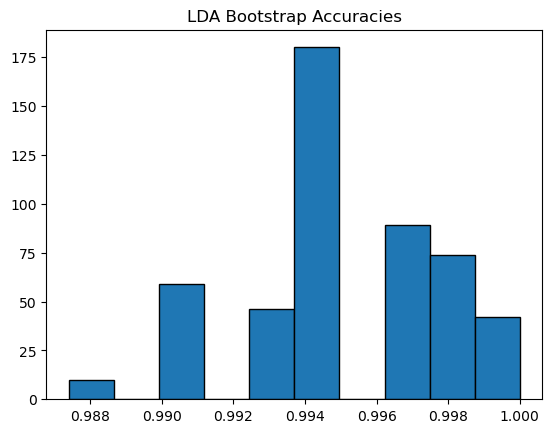

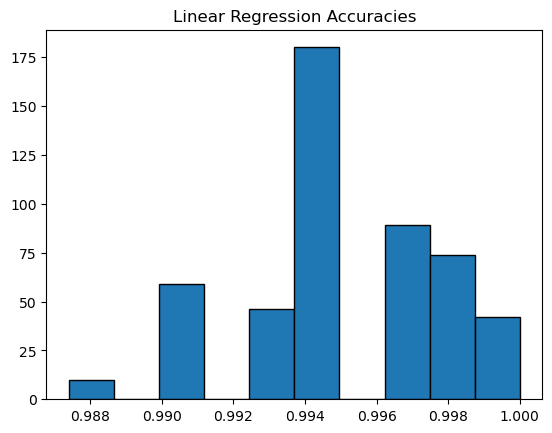

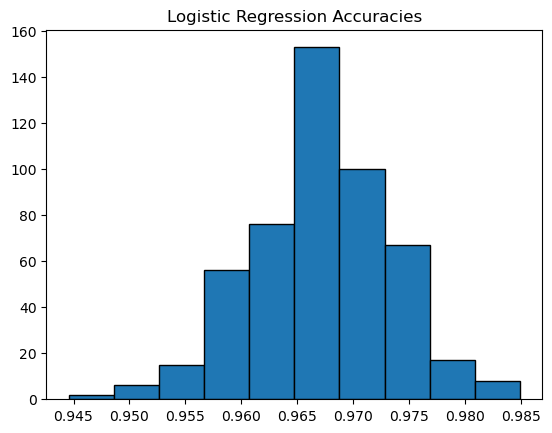

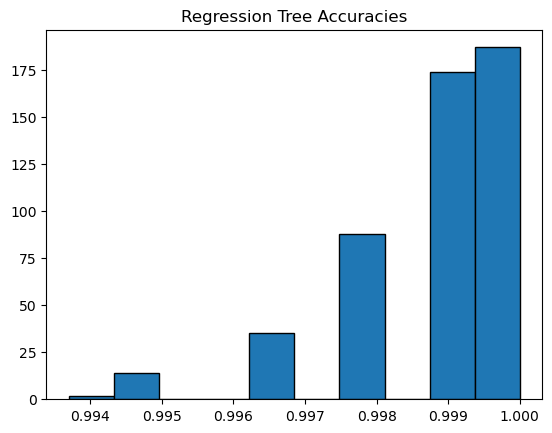

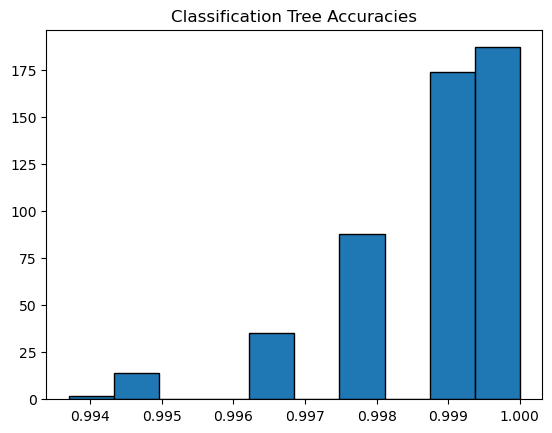

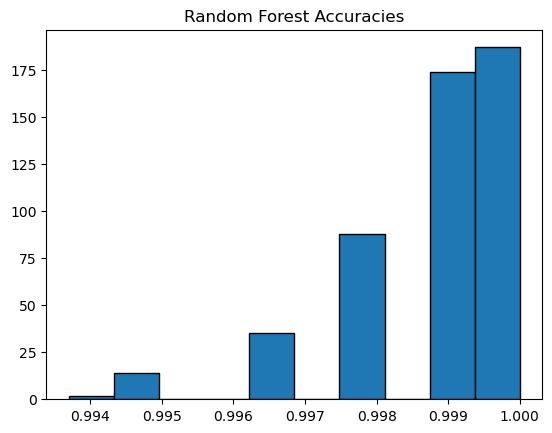

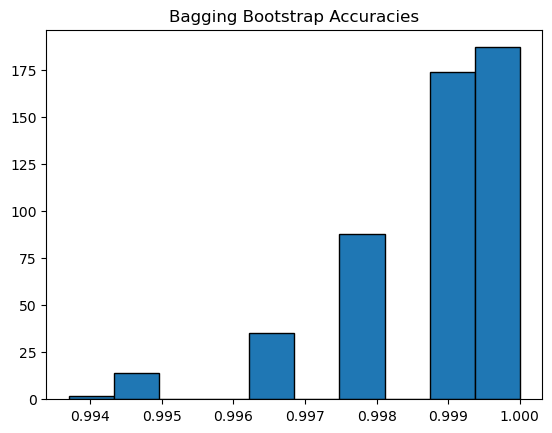

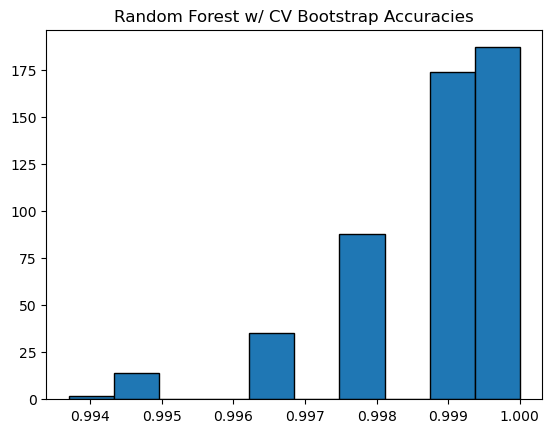

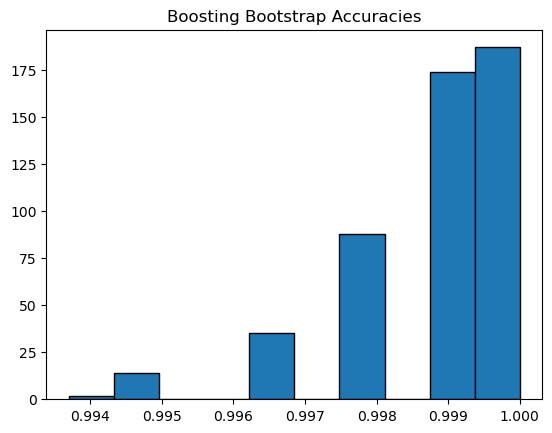

In [71]:
plt.hist(result['LDA'], edgecolor = 'black')
plt.title('LDA Bootstrap Accuracies')
plt.show()

plt.hist(result['Linear Reg'], edgecolor = 'black')
plt.title('Linear Regression Accuracies')
plt.show()

plt.hist(result['Logistic Reg'], edgecolor = 'black')
plt.title('Logistic Regression Accuracies')
plt.show()

plt.hist(result['Regression tree'], edgecolor = 'black')
plt.title('Regression Tree Accuracies')
plt.show()

plt.hist(result['Classification tree'], edgecolor = 'black')
plt.title('Classification Tree Accuracies')
plt.show()

plt.hist(result['Random Forest'], edgecolor = 'black')
plt.title('Random Forest Accuracies')
plt.show()

plt.hist(result['RF w/ Bagging'], edgecolor = 'black')
plt.title('Bagging Bootstrap Accuracies')
plt.show()

plt.hist(result['RF w/ CV'], edgecolor = 'black')
plt.title('Random Forest w/ CV Bootstrap Accuracies')
plt.show()

plt.hist(result['Boosting'], edgecolor = 'black')
plt.title('Boosting Bootstrap Accuracies')
plt.show()

In [72]:
lda_acc = result['LDA'].mean()
linear_acc = result['Linear Reg'].mean()
logreg_acc = result['Logistic Reg'].mean()
reg_tree_acc = result['Regression tree'].mean()
class_tree_acc = result['Classification tree'].mean()
rf_acc = result['Random Forest'].mean()
rf_bagging_acc = result['RF w/ Bagging'].mean()
rf_cv_acc = result['RF w/ CV'].mean()
gbc_acc = result['Boosting'].mean()

lda_tpr = result['LDA TPR'].mean()
linear_tpr = result['Linear Reg TPR'].mean()
logreg_tpr = result['Logistic Reg TPR'].mean()
reg_tree_tpr = result['Regression tree TPR'].mean()
class_tree_tpr = result['Classification tree TPR'].mean()
rf_tpr = result['Random Forest TPR'].mean()
rf_bagging_tpr = result['RF w/ Bagging TPR'].mean()
rf_cv_tpr = result['RF w/ CV TPR'].mean()
gbc_tpr = result['Boosting TPR'].mean()

lda_fpr = result['LDA FPR'].mean()
linear_fpr = result['Linear Reg FPR'].mean()
logreg_fpr = result['Logistic Reg FPR'].mean()
reg_tree_fpr = result['Regression tree FPR'].mean()
class_tree_fpr = result['Classification tree FPR'].mean()
rf_fpr = result['Random Forest FPR'].mean()
rf_bagging_fpr = result['RF w/ Bagging FPR'].mean()
rf_cv_fpr = result['RF w/ CV FPR'].mean()
gbc_fpr = result['Boosting FPR'].mean()

accuracies = [baseline_acc, lda_acc, linear_acc, logreg_acc, reg_tree_acc, class_tree_acc, rf_acc, rf_bagging_acc, rf_cv_acc, gbc_acc]
tpr_values = [baseline_tpr, lda_tpr, linear_tpr, logreg_tpr, reg_tree_tpr, class_tree_tpr, rf_tpr, rf_bagging_tpr, rf_cv_tpr, gbc_tpr]
fpr_values = [baseline_fpr, lda_fpr, linear_fpr, logreg_fpr, reg_tree_fpr, class_tree_fpr, rf_fpr, rf_bagging_fpr, rf_cv_fpr, gbc_fpr]

data = {'Accuracy (Mean Boostrap)' : accuracies,
        'TPR (Mean Bootstrap)' : tpr_values,
        'FPR (Mean Bootsrap)' : fpr_values}

metrics_table = pd.DataFrame(data, index = ['Baseline',
                                            'LDA',
                                            'Linear',
                                            'Logistic',
                                            'Regression tree',
                                            'Classification tree',
                                            'Random Forest',
                                            'RF w/ Vanilla Bagging',
                                            'RF w/ Cross Validation',
                                            'Gradient Boosting Classifier'])

metrics_table

,Accuracy (Mean Boostrap),TPR (Mean Bootstrap),FPR (Mean Bootsrap)
Baseline,0.954660,0.000000,0.000000
LDA,0.994856,0.886722,0.000000
Linear,0.994856,0.886722,0.000000
Logistic,0.967055,0.753459,0.022815
Regression tree,0.998688,0.970960,0.000000
Classification tree,0.998688,0.970960,0.000000
Random Forest,0.998688,0.970960,0.000000
RF w/ Vanilla Bagging,0.998688,0.970960,0.000000
RF w/ Cross Validation,0.998688,0.970960,0.000000
Gradient Boosting Classifier,0.998688,0.970960,0.000000
